In [52]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Functions

In [53]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov(cdist(x, X)) @ np.linalg.solve(sigma, Y)

In [54]:
def co_kriging(x, X_1, X_2, Y, sigma):
    c = np.block([[matern_1(cdist(x, X_1)), rho_12 * np.nan_to_num(matern_12(cdist(x, X_2)), nan=1)],
                  [rho_12 * np.nan_to_num(matern_12(cdist(x, X_1)), nan=1), matern_2(cdist(x, X_2))]])
    c = np.nan_to_num(c, nan=1)
    return c @ np.linalg.solve(sigma, Y)

In [55]:
def scatterplot(X,Y,title='',xlabel='',ylabel='',figsize=(7,6)):
    # plt.figure(figsize=figsize)
    plt.scatter(X,Y)
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], [min(min(X), min(Y)), max(max(X), max(Y))], ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    # plt.show()

Leave-one-out functions

In [56]:
def leave_one_out_univariate(X, Y, sigma, cov):
    Y_pred = []
    for i in range(0, X.shape[0]):
        sigma_aux = np.delete(np.delete(sigma, i, axis=0), i, axis=1)
        X_aux = np.delete(X, i, axis=0)
        Y_aux = np.delete(Y, i, axis=0)
        Y_pred.append(kriging(X[[i]], X_aux, Y_aux, sigma_aux, cov))
    return np.array(Y_pred).reshape(-1)

In [57]:
def leave_one_out_bivariate(X_1, X_2, Y, sigma, how='Y_1'):
    n = X_1.shape[0]
    m = X_2.shape[0]
    Y_pred = []
    if how == 'Y_1':
        for i in range(0,n):
            sigma_aux = np.delete(np.delete(sigma, i, axis=0), i, axis=1)
            X_aux = np.delete(X_1, i, axis=0)
            Y_aux = np.delete(Y, i, axis=0)
            Y_pred.append(co_kriging(X_1[[i]], X_aux, X_2, Y_aux, sigma_aux)[0])
    
    if how == 'Y_2':
        for j in range(0,m):
            sigma_aux = np.delete(np.delete(sigma, j+n, axis=0), j+n, axis=1)
            X_aux = np.delete(X_2, j, axis=0)
            Y_aux = np.delete(Y, j+n, axis=0)
            Y_pred.append(co_kriging(X_2[[j]], X_1, X_aux, Y_aux, sigma_aux)[1])
    
    elif how == 'both':
        if m!=n or not np.allclose(X_1, X_2):
            raise ValueError("If 'how'='both', the observation points must be the same for both variables.")
    
        for i in range(0,n):
            sigma_aux = np.delete(np.delete(sigma, [i,i+n], axis=0), [i,i+n], axis=1)
            X_aux = np.delete(X_1, i, axis=0)
            Y_aux = np.delete(Y, [i, i+n], axis=0)
            Y_pred.append(co_kriging(X_1[[i]], X_aux, X_aux, Y_aux, sigma_aux))
        
    return np.array(Y_pred)

Matérn con $K_\nu$

In [58]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

Observations points

In [59]:
d = 2
n = 700
m = 700
sup = 20 # min(n,m)
X_1 = np.random.uniform(0, sup, (n,d))
# X_2 = np.random.uniform(0, sup, (m,d))
X_2 = X_1

Parameters

In [60]:
nu_1 = 11/2
theta_1 = 50/sup

nu_2 = 7/2
theta_2 = 70/sup

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [61]:
rho_12

0.696425745031121

In [62]:
# set parameters paper
# https://amath.colorado.edu/faculty/kleiberw/papers/Gneiting2010.pdf
# Figure 1

# sup = 20

nu_1 = 3/2
theta_1 = 1

nu_2 = 1/2
theta_2 = 0.2

nu_12 = 1
theta_12 = 0.6
rho_12 = 0.5


Models

In [63]:
matern_1 = matern_model(theta_1, nu_1)
matern_2 = matern_model(theta_2, nu_2)
matern_12 = matern_model(theta_12, nu_12)

Covariance matrices

In [64]:
sigma_1 = np.nan_to_num(matern_1(cdist(X_1,X_1)), nan=1)
sigma_2 = np.nan_to_num(matern_2(cdist(X_2,X_2)), nan=1)
sigma_12 = rho_12 * np.nan_to_num(matern_12(cdist(X_1,X_2)), nan=1)

In [65]:
sigma = np.block([[sigma_1, sigma_12],
                  [sigma_12.T, sigma_2]])

In [66]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+m))

Y_1 = Y[:n]
Y_2 = Y[n:]

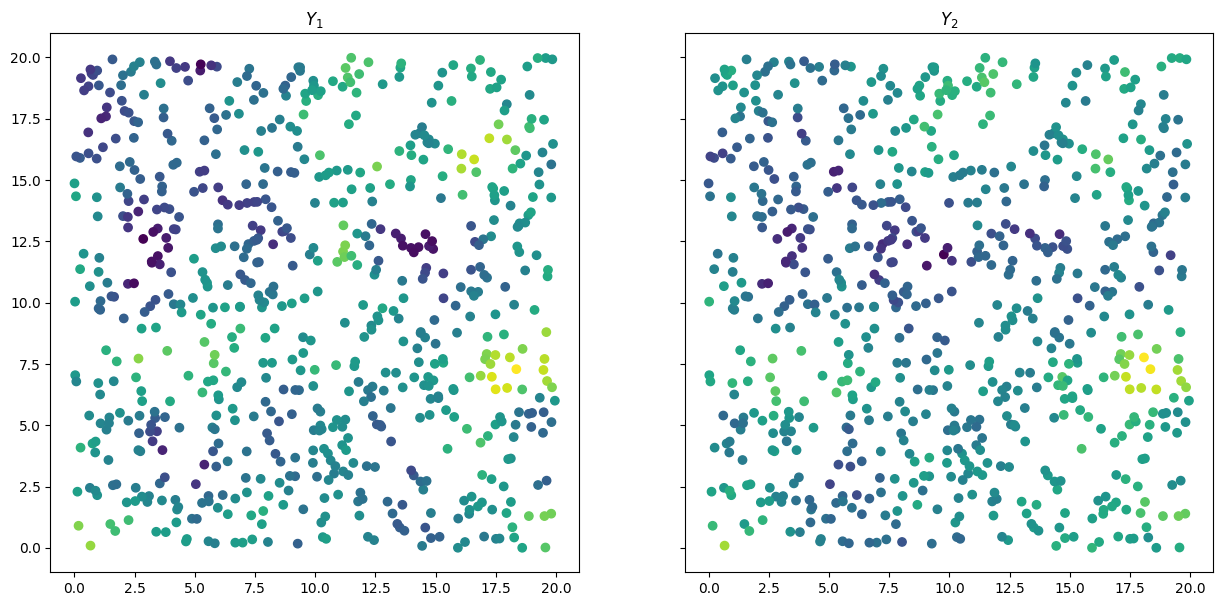

In [67]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))

ax1.scatter(X_1[:,0], X_1[:,1], c=Y_1)
ax1.set_title(r'$Y_1$')
ax2.scatter(X_2[:,0], X_2[:,1], c=Y_2)
ax2.set_title(r'$Y_2$');

In [68]:
results = []

Kriging simple

RMSE = 0.1921615037458246


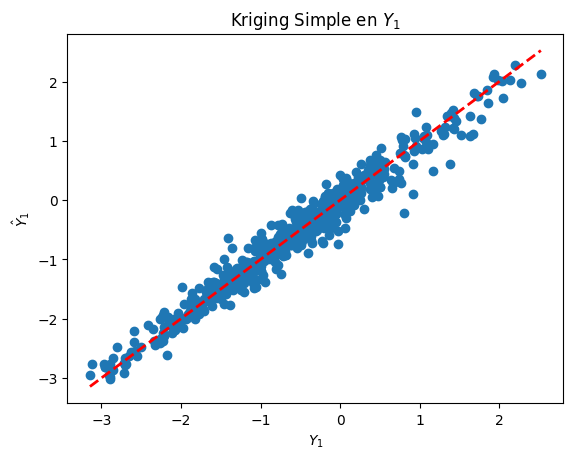

In [69]:
Y_pred = leave_one_out_univariate(X_1, Y_1, sigma_1, matern_1)

RMSE = root_mean_squared_error(Y_1, Y_pred)
print(f'{RMSE = }')

scatterplot(Y_1, Y_pred, title=r'Kriging Simple en $Y_1$', xlabel=r'$Y_1$', ylabel=r'$\hat{Y}_1$')

results.append(('Kriging simple Y_1', RMSE, np.nan))

RMSE = 0.29955162231309673


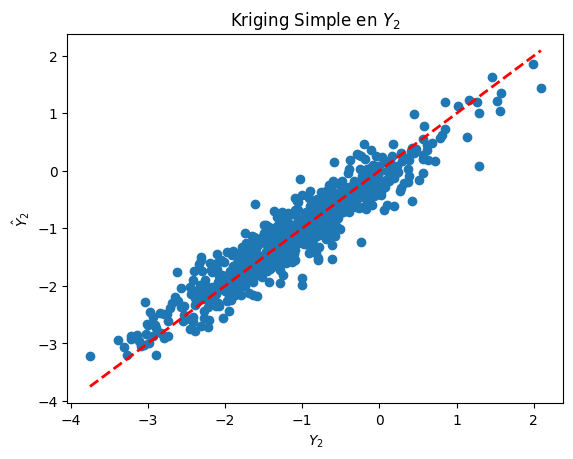

In [70]:
Y_pred = leave_one_out_univariate(X_2, Y_2, sigma_2, matern_2)

RMSE = root_mean_squared_error(Y_2, Y_pred)
print(f'{RMSE = }')

scatterplot(Y_2, Y_pred, title=r'Kriging Simple en $Y_2$', xlabel=r'$Y_2$', ylabel=r'$\hat{Y}_2$')

results.append(('Kriging simple Y_2', np.nan, RMSE))

coKriging

RMSE = 0.1759507850061163


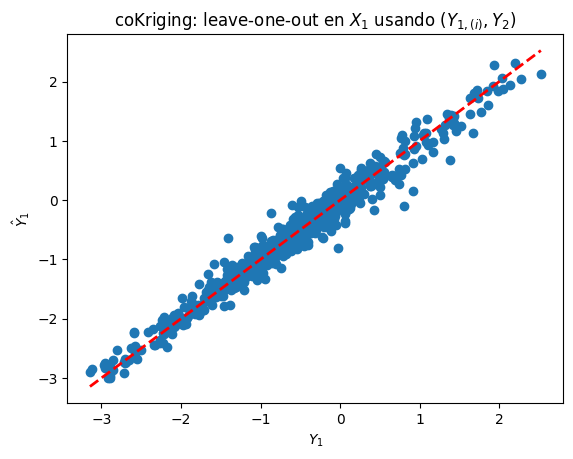

In [71]:
Y_pred = leave_one_out_bivariate(X_1, X_2, Y, sigma, how='Y_1')

RMSE = root_mean_squared_error(Y_1, Y_pred)
print(f'{RMSE = }')

scatterplot(Y_1, Y_pred, title=r'coKriging: leave-one-out en $X_1$ usando $(Y_{1,(i)}, Y_2)$', xlabel=r'$Y_1$', ylabel=r'$\hat{Y}_1$')

results.append(('coKriging leave-one-out usando todo Y_2', RMSE, np.nan))

RMSE = 0.27345616128565314


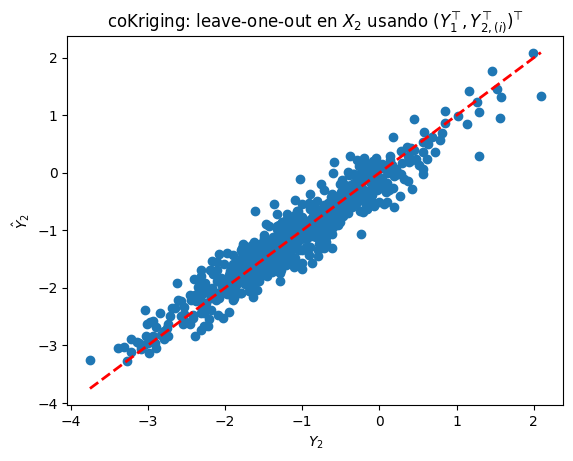

In [72]:
Y_pred = leave_one_out_bivariate(X_1, X_2, Y, sigma, how='Y_2')

RMSE = root_mean_squared_error(Y_2, Y_pred)
print(f'{RMSE = }')

scatterplot(Y_2, Y_pred, title=r'coKriging: leave-one-out en $X_2$ usando $(Y_1^\top, Y_{2,(i)}^\top)^\top$', xlabel=r'$Y_2$', ylabel=r'$\hat{Y}_2$')

results.append(('coKriging leave-one-out usando todo Y_1', np.nan, RMSE))

Leave-one-out observation point

solo si $X_1 = X_2$

In [73]:
Y_pred = leave_one_out_bivariate(X_1, X_2, Y, sigma, how='both')

RMSE_1 = 0.1909270163211786
RMSE_2 = 0.29743817293614205


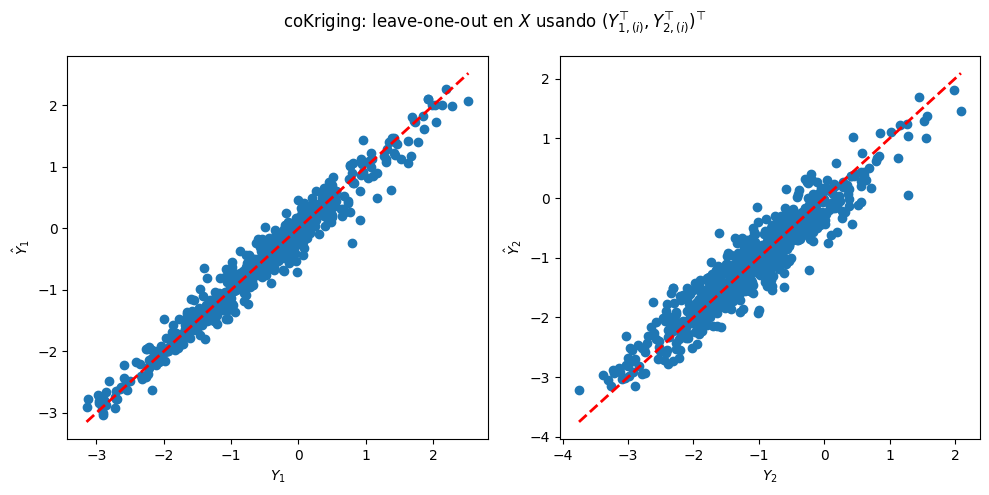

In [74]:
RMSE_1 = root_mean_squared_error(Y_1, Y_pred[:,0])
print(f'{RMSE_1 = }')

RMSE_2 = root_mean_squared_error(Y_2, Y_pred[:,1])
print(f'{RMSE_2 = }')


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
scatterplot(Y_1, Y_pred[:,0], xlabel=r'$Y_1$', ylabel=r'$\hat{Y}_1$')
plt.subplot(1,2,2)
scatterplot(Y_2, Y_pred[:,1], xlabel=r'$Y_2$', ylabel=r'$\hat{Y}_2$')
plt.suptitle(r'coKriging: leave-one-out en $X$ usando $(Y_{1,(i)}^\top, Y_{2,(i)}^\top)^\top$')
plt.tight_layout()

results.append(('coKriging leave-one-out observation point', RMSE_1, RMSE_2))

In [75]:
df = pd.DataFrame(data=results, columns=['Método', 'RMSE Y_1', 'RMSE Y_2'])
df

,Método,RMSE Y_1,RMSE Y_2
0,Kriging simple Y_1,0.192162,NaN
1,Kriging simple Y_2,NaN,0.299552
2,coKriging leave-one-out usando todo Y_2,0.175951,NaN
3,coKriging leave-one-out usando todo Y_1,NaN,0.273456
4,coKriging leave-one-out observation point,0.190927,0.297438
